In [2]:
import cv2

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import numpy as np
import cv2

# ---- Device ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [4]:
# ============================================================
# 1. DATASET VARIATIONS (same as feature extraction)
# ============================================================

def get_dataloaders(variation, batch_size=64):
    normalize = transforms.Normalize((0.5,), (0.5,))

    base_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    normalized_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        normalize
    ])

    augment_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ColorJitter(brightness=0.2),
        transforms.ToTensor(),
        normalize
    ])

    # Pick transform based on variation
    if variation == "base":
        transform_train = base_transform
        transform_test = base_transform
    elif variation == "normalized":
        transform_train = normalized_transform
        transform_test = normalized_transform
    elif variation == "augmented":
        transform_train = augment_transform
        transform_test = normalized_transform
    elif variation == "augmented+regularized":
        transform_train = augment_transform
        transform_test = normalized_transform
    else:
        raise ValueError("Variation must be base, normalized, augmented, or augmented+regularized")

    train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform_train)
    test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
    return train_loader, test_loader, test_dataset

In [5]:
# ============================================================
# 2. RESNET ARCHITECTURE
# ============================================================

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out = out.clone() + identity
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 64, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 128, layers[3], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

In [6]:
# ============================================================
# 3. TRAINING FUNCTION
# ============================================================

def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()
    history = {"train_loss": [], "train_acc": []}

    for epoch in range(num_epochs):
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        history["train_loss"].append(epoch_loss)
        history["train_acc"].append(epoch_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}%")

    return history

In [7]:
# ============================================================
# 4. EVALUATION FUNCTION
# ============================================================

def evaluate_model(model, test_loader, device):
    model.eval()
    preds, labels_list = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())

    acc = accuracy_score(labels_list, preds)
    prec = precision_score(labels_list, preds, average='macro')
    rec = recall_score(labels_list, preds, average='macro')
    f1 = f1_score(labels_list, preds, average='macro')

    print(f"\nAccuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

    cm = confusion_matrix(labels_list, preds)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return acc, prec, rec, f1

In [8]:
# ============================================================
# 5. GradCAM
# ============================================================

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach().clone()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_image, target_class=None):
        self.model.zero_grad()
        output = self.model(input_image)
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        output.backward(gradient=one_hot, retain_graph=True)
        grads = self.gradients
        acts = self.activations
        weights = grads.mean(dim=(2, 3), keepdim=True)
        cam = (weights * acts).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam, target_class


In [9]:
# ============================================================
# 6. AUTOMATED TRAINING LOOP (All Variations)
# ============================================================

variations = ["base", "normalized", "augmented", "augmented+regularized"]
results = {}

for variation in variations:
    print(f"\n==================== {variation.upper()} ====================")
    train_loader, test_loader, test_dataset = get_dataloaders(variation)
    model = ResNet(ResidualBlock, [2, 2, 2, 2]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001,
                           weight_decay=1e-4 if "regularized" in variation else 0)

    history = train_model(model, train_loader, criterion, optimizer, device, num_epochs=10)
    acc, prec, rec, f1 = evaluate_model(model, test_loader, device)
    results[variation] = {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "history": history}

    # ---- Grad-CAM Visualizations ----
    grad_cam = GradCAM(model, model.layer4[-1].conv2)
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,4))
    axes_flat = axes.flatten()

    for i in range(10):
        ax = axes_flat[i]
        idx = np.where(np.array(test_dataset.targets) == i)[0][0]
        img, _ = test_dataset[idx]
        input_tensor = img.unsqueeze(0).to(device)
        input_tensor.requires_grad_()
        cam, cls = grad_cam.generate(input_tensor)
        cam_resized = cv2.resize(cam, (img.shape[2], img.shape[1]))

        ax.imshow(img.squeeze().cpu().numpy(), cmap="gray")
        ax.imshow(cam_resized, cmap="jet", alpha=0.5)
        ax.set_title(f"Label {i}, Pred {cls}")
        ax.axis("off")

    plt.suptitle(f"GradCAM - {variation.upper()}")
    plt.tight_layout()
    plt.show()


==================== BASE ====================


Epoch 1/10: 100%|██████████| 938/938 [04:35<00:00,  3.41it/s]


Epoch [1/10] | Loss: 0.2802 | Acc: 93.35%


Epoch 2/10: 100%|██████████| 938/938 [04:58<00:00,  3.15it/s]


Epoch [2/10] | Loss: 0.0657 | Acc: 98.16%


Epoch 3/10: 100%|██████████| 938/938 [05:21<00:00,  2.92it/s]


Epoch [3/10] | Loss: 0.0482 | Acc: 98.62%


Epoch 4/10:   5%|▌         | 48/938 [00:17<05:23,  2.75it/s]


KeyboardInterrupt: 

/home/bryan_santosa/miniconda3/envs/machinelearning/lib/python3.10/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


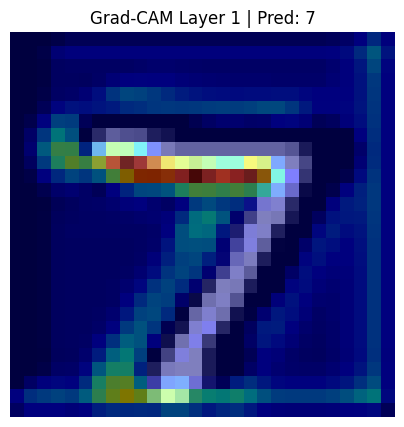

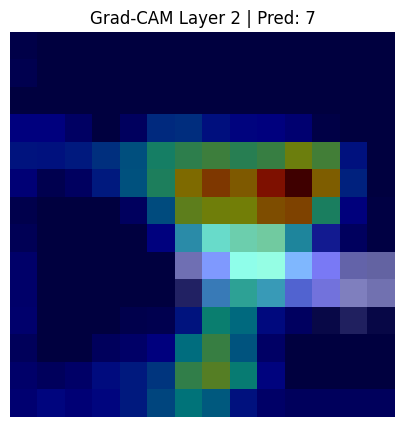

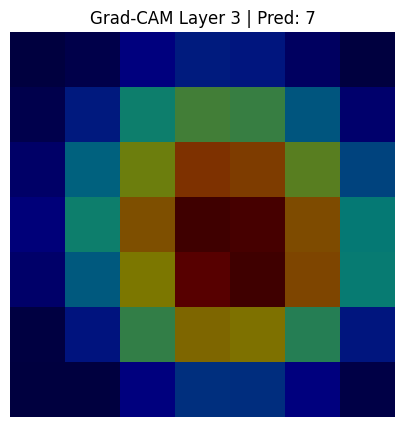

In [ ]:
    # ============================================================
# 7. PLOT LOSS & ACCURACY COMPARISON
# ============================================================

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
for v in variations:
    plt.plot(results[v]["history"]["train_loss"], label=f"{v}")
plt.title("Loss Curve Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
for v in variations:
    plt.plot(results[v]["history"]["train_acc"], label=f"{v}")
plt.title("Accuracy Curve Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()